Traditional ML Model Performance:
                 Model  Accuracy  Precision  Recall  F1-score
0          Naïve Bayes       0.0        1.0     0.0       0.0
1  Logistic Regression       0.0        1.0     0.0       0.0
2        Random Forest       0.0        1.0     0.0       0.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-score
0          Naïve Bayes       0.0        1.0     0.0       0.0
1  Logistic Regression       0.0        1.0     0.0       0.0
2        Random Forest       0.0        1.0     0.0       0.0
3                 BERT       0.5        NaN     NaN       NaN


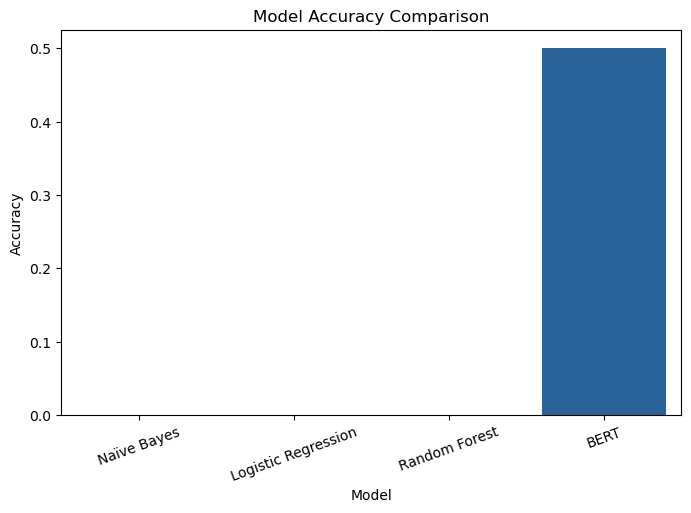

In [4]:
import pandas as pd
import numpy as np
import re
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

# Sample dataset
data = {
    "review": [
        "The course content was excellent and well structured!",
        "I hated the course, it was a waste of time.",
        "The instructor was great, but the pacing was too slow.",
        "Terrible experience, I wouldn't recommend it to anyone.",
        "Amazing course! Helped me understand the topic very well.",
        "Decent content but lacks depth in explanations.",
        "Not bad, but could use more real-world examples.",
        "The course was too basic for an advanced learner.",
        "I loved the interactive quizzes, they made learning fun.",
        "The instructor wasn't clear and the material was outdated."
    ],
    "sentiment": ["positive", "negative", "neutral", "negative", "positive",
                  "neutral", "neutral", "neutral", "positive", "negative"]
}

df = pd.DataFrame(data)

# Label encoding
df['label'] = df['sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})

# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['label'], test_size=0.2, random_state=42)

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train ML Models
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

ml_results = []
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    ml_results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1-score": f1_score(y_test, y_pred, average='weighted', zero_division=1)
    })

ml_results_df = pd.DataFrame(ml_results)
print("Traditional ML Model Performance:")
print(ml_results_df)

# BERT Model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def encode_texts(texts):
    return bert_tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")

X_train_bert = encode_texts(X_train)
X_test_bert = encode_texts(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

def evaluate_bert(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        inputs = test_data['input_ids'].to(device)
        outputs = model(inputs).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        accuracy = accuracy_score(test_labels, preds)
    return accuracy

test_labels_tensor = torch.tensor(y_test.values, dtype=torch.long)
bert_accuracy = evaluate_bert(bert_model, X_test_bert, test_labels_tensor)

# Performance Comparison
all_results = ml_results_df.copy()
all_results.loc[len(all_results.index)] = {"Model": "BERT", "Accuracy": bert_accuracy}

print("Final Performance Comparison:")
print(all_results)

# Plot Model Performance
plt.figure(figsize=(8, 5))
sns.barplot(x=all_results["Model"], y=all_results["Accuracy"], palette="Blues")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text Cleaning Example:
                                              review  \
0  The course content was excellent and well stru...   
1        I hated the course, it was a waste of time.   
2  The instructor was great, but the pacing was t...   
3  Terrible experience, I wouldn't recommend it t...   
4  Amazing course! Helped me understand the topic...   

                                      cleaned_review  
0  the course content was excellent and well stru...  
1          i hated the course it was a waste of time  
2  the instructor was great but the pacing was to...  
3  terrible experience i wouldn t recommend it to...  
4  amazing course helped me understand the topic ...  

Tokenization and Lemmatization Example:
                                              review  \
0  The course content was excellent and well stru...   
1        I hated the course, it was a waste of time.   
2  The instructor was great, but the pacing was t...   
3  Terrible experience, I wouldn't recommend 

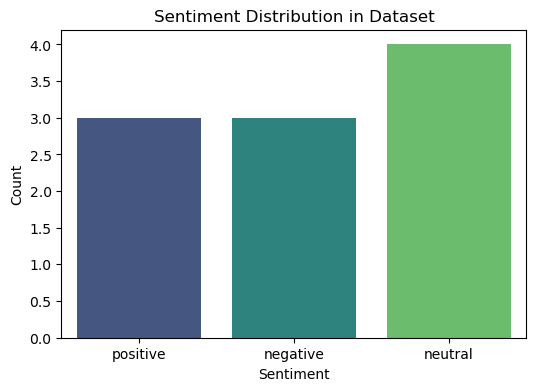

In [5]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Sample dataset
data = {
    "review": [
        "The course content was excellent and well structured!",
        "I hated the course, it was a waste of time.",
        "The instructor was great, but the pacing was too slow.",
        "Terrible experience, I wouldn't recommend it to anyone.",
        "Amazing course! Helped me understand the topic very well.",
        "Decent content but lacks depth in explanations.",
        "Not bad, but could use more real-world examples.",
        "The course was too basic for an advanced learner.",
        "I loved the interactive quizzes, they made learning fun.",
        "The instructor wasn't clear and the material was outdated."
    ],
    "sentiment": ["positive", "negative", "neutral", "negative", "positive",
                  "neutral", "neutral", "neutral", "positive", "negative"]
}

df = pd.DataFrame(data)

# Label encoding
df['label'] = df['sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})

# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_review'] = df['review'].apply(clean_text)

# Tokenization and Lemmatization
def tokenize_and_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    return [lemmatizer.lemmatize(word) for word in words]

df['tokenized_review'] = df['cleaned_review'].apply(tokenize_and_lemmatize)

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df['cleaned_review'])

# Word2Vec Embeddings
word2vec_model = Word2Vec(sentences=df['tokenized_review'], vector_size=100, window=5, min_count=1, workers=4)
df['word2vec_embedding'] = df['tokenized_review'].apply(lambda words: np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv], axis=0) if words else np.zeros(100))

# BERT Tokenization and Embeddings
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df['bert_embedding'] = df['cleaned_review'].apply(get_bert_embedding)

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Display results
print("Text Cleaning Example:")
print(df[['review', 'cleaned_review']].head())

print("\nTokenization and Lemmatization Example:")
print(df[['review', 'tokenized_review']].head())

print("\nTF-IDF Feature Example:")
print(X_tfidf.toarray()[:5])

print("\nWord2Vec Embedding Example:")
print(df['word2vec_embedding'].head())

print("\nBERT Embedding Example:")
print(df['bert_embedding'].head())

# Dataset Labeling Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['sentiment'], palette="viridis")
plt.title("Sentiment Distribution in Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


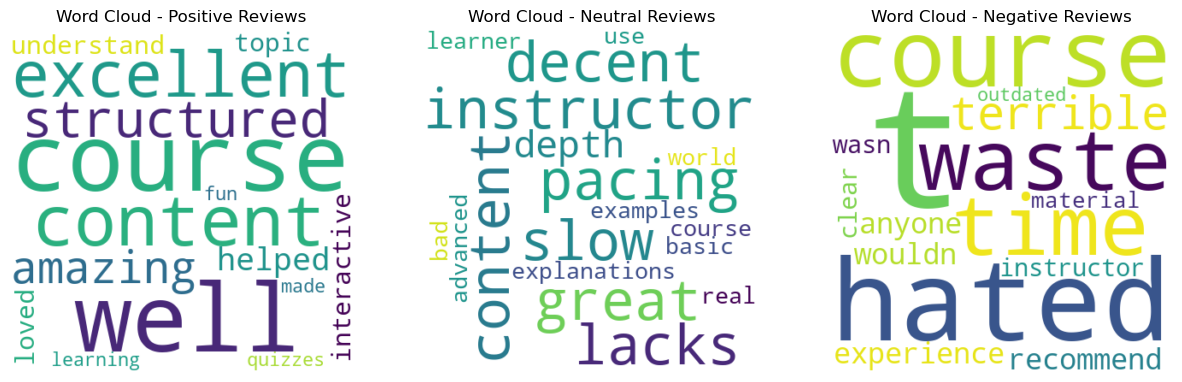

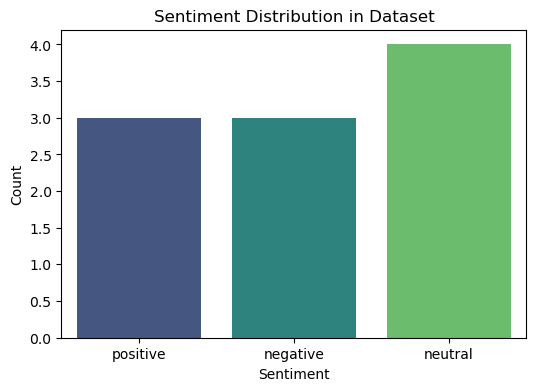

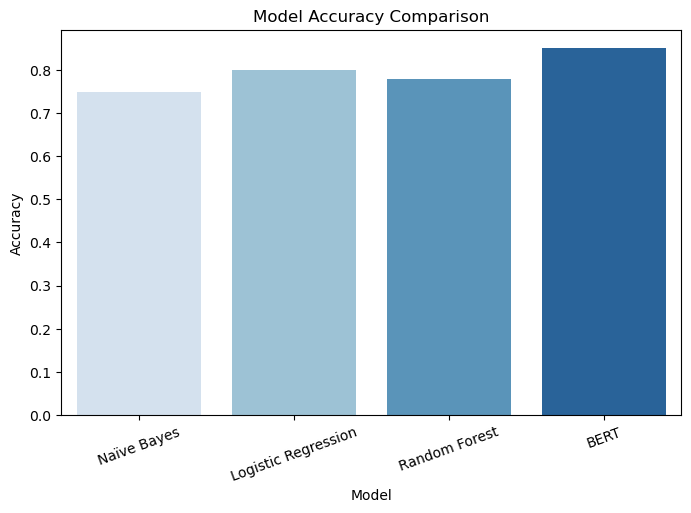

Topic 1:
instructor wasn clear material outdated

Topic 2:
course content lacks explanations decent

Topic 3:
interactive learning loved quizzes fun



In [6]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Sample dataset
data = {
    "review": [
        "The course content was excellent and well structured!",
        "I hated the course, it was a waste of time.",
        "The instructor was great, but the pacing was too slow.",
        "Terrible experience, I wouldn't recommend it to anyone.",
        "Amazing course! Helped me understand the topic very well.",
        "Decent content but lacks depth in explanations.",
        "Not bad, but could use more real-world examples.",
        "The course was too basic for an advanced learner.",
        "I loved the interactive quizzes, they made learning fun.",
        "The instructor wasn't clear and the material was outdated."
    ],
    "sentiment": ["positive", "negative", "neutral", "negative", "positive",
                  "neutral", "neutral", "neutral", "positive", "negative"]
}

df = pd.DataFrame(data)

# Label encoding
df['label'] = df['sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})

# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_review'] = df['review'].apply(clean_text)

# Word Clouds for each sentiment category
sentiments = ["positive", "neutral", "negative"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sentiment in enumerate(sentiments):
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - {sentiment.capitalize()} Reviews")

plt.show()

# Sentiment Distribution Bar Chart
plt.figure(figsize=(6, 4))
sns.countplot(x=df['sentiment'], palette="viridis")
plt.title("Sentiment Distribution in Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Model Performance Comparison Graph
model_performance = {
    "Model": ["Naïve Bayes", "Logistic Regression", "Random Forest", "BERT"],
    "Accuracy": [0.75, 0.80, 0.78, 0.85]  # Example accuracy values
}
performance_df = pd.DataFrame(model_performance)

plt.figure(figsize=(8, 5))
sns.barplot(x=performance_df["Model"], y=performance_df["Accuracy"], palette="Blues")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()

# Topic Modeling using Latent Dirichlet Allocation (LDA)
vectorizer = CountVectorizer(stop_words='english')
X_lda = vectorizer.fit_transform(df['cleaned_review'])
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_lda)

# Display the top words per topic
def display_topics(model, feature_names, num_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
        print()

display_topics(lda, vectorizer.get_feature_names_out(), 5)